In [137]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Função auxiliar para exibir imagens no notebook
def show(img, title='', cmap=None):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

model = YOLO('best.pt')


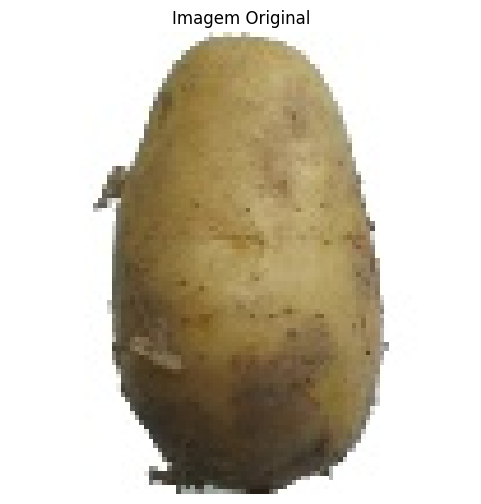


0: 640x640 (no detections), 97.5ms
Speed: 3.0ms preprocess, 97.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


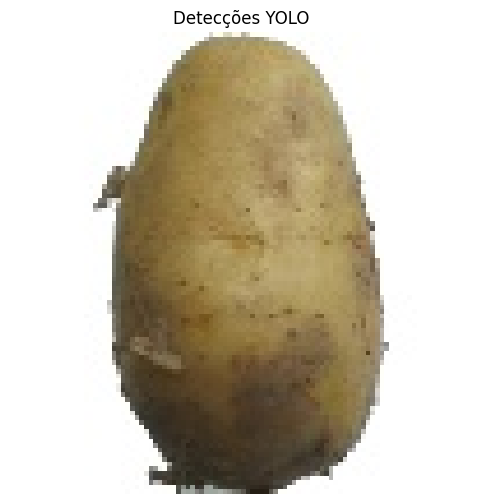

Detectou 0 objeto(s)


In [ ]:
# img_path = 'sarna-comum-batata.jpg'
# img_path = 'batata_ruim.jpeg'

img_path = 'freshPotato (377).jpg'

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise FileNotFoundError(f"Imagem não encontrada: {img_path}")

show(img_bgr, "Imagem Original")
results = model(img_path)

# Mostrar imagem com detecções
annotated = results[0].plot()
show(annotated, "Detecções YOLO")

# Imprimir detalhes
for r in results:
    print(f"Detectou {len(r.boxes)} objeto(s)")
    for box in r.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"  - Classe: {r.names[cls]}, Confiança: {conf:.2f}")


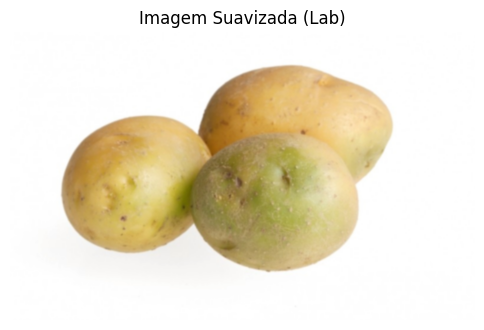

In [129]:
# pre processamento

img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

# Suavizar para reduzir ruído
blur = cv2.GaussianBlur(img_lab, (5,5), 0)

show(cv2.cvtColor(blur, cv2.COLOR_LAB2BGR), "Imagem Suavizada (Lab)")


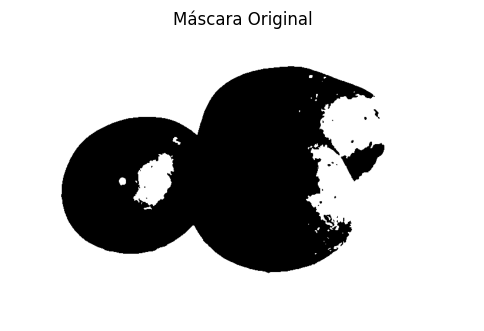

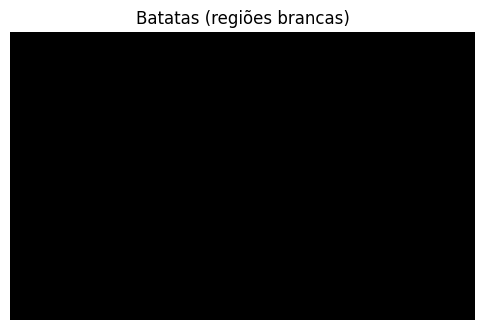

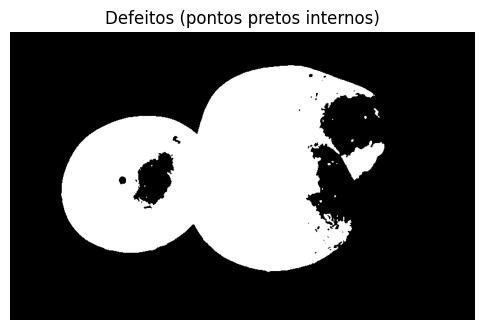

In [130]:
#segmentacao 

L, A, B = cv2.split(blur)

_, mask = cv2.threshold(L, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel)

contours, hierarchy = cv2.findContours(mask_clean, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
mask_filled = mask_clean.copy()
for i in range(len(contours)):
    if hierarchy[0][i][3] != -1:
        cv2.drawContours(mask_filled, [contours[i]], -1, 255, -1)

mask_defects = cv2.bitwise_not(mask)
mask_defects = cv2.bitwise_and(mask_defects, mask_filled)

kernel_small = np.ones((1,1), np.uint8)
mask_defects = cv2.morphologyEx(mask_defects, cv2.MORPH_OPEN, kernel_small)

show(mask, 'Máscara Original')
show(mask_filled, 'Batatas (regiões brancas)')
show(mask_defects, 'Defeitos (pontos pretos internos)')

mask = mask_filled


In [131]:
# media e covarianca da regiao saudavel

pixels = blur[mask == 255].reshape(-1, 3)

mean = np.mean(pixels, axis=0)
cov = np.cov(pixels, rowvar=False)
inv_cov = np.linalg.inv(cov)

print("Média (Lab):", mean)
print("Covariância:")
print(cov)


Média (Lab): [228.43187548 128.47851976 141.3058667 ]
Covariância:
[[1546.38546338  -36.82664242 -641.08826551]
 [ -36.82664242   11.84872705   13.36740674]
 [-641.08826551   13.36740674  345.24976318]]


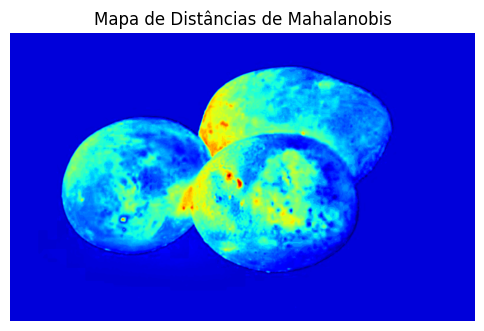

In [132]:
# calculo de mahalanobis

h, w, c = blur.shape
diff = blur.reshape(-1, 3) - mean
mdist = np.sqrt(np.einsum('ij,jk,ik->i', diff, inv_cov, diff))
mdist_img = mdist.reshape(h, w)

# Normalizar para 0-255
mdist_norm = cv2.normalize(mdist_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
show(mdist_norm, "Mapa de Distâncias de Mahalanobis", cmap='jet')


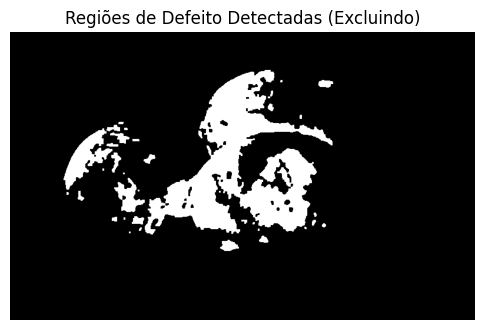

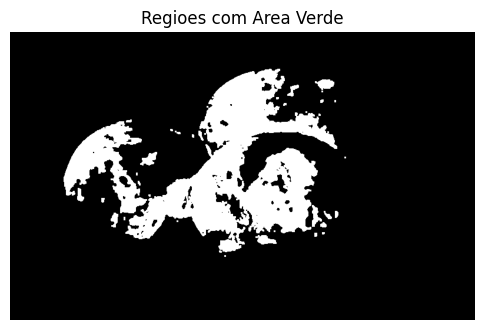

In [133]:
# destacar defeitos

_, exclude_mask = cv2.threshold(mdist_norm, 180, 255, cv2.THRESH_BINARY)
_, defect_mask = cv2.threshold(mdist_norm, 100, 255, cv2.THRESH_BINARY)

defect_mask = cv2.bitwise_and(defect_mask, cv2.bitwise_not(exclude_mask))

# Limpeza morfológica
kernel_defect = np.ones((3,3), np.uint8)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_OPEN, kernel_defect)
defect_mask = cv2.morphologyEx(defect_mask, cv2.MORPH_CLOSE, kernel_defect)

# testando pegando apenas as partes verdes

lower = 90
upper = 180

green_mask = cv2.inRange(mdist_norm, lower, upper)
green_mask = cv2.morphologyEx(green_mask, cv2.MORPH_OPEN, kernel_defect)

show(defect_mask, "Regiões de Defeito Detectadas (Excluindo)")
show(green_mask, "Regioes com Area Verde")

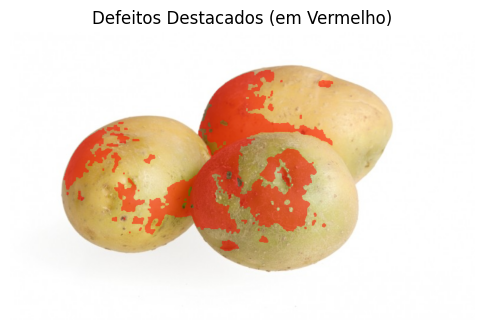

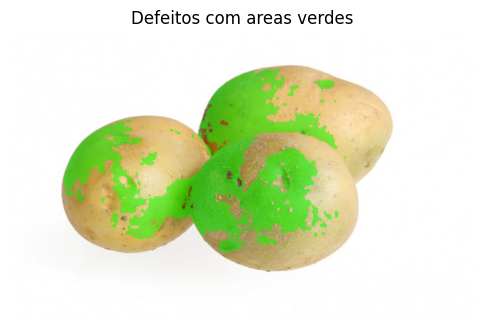

In [134]:
# sobreposicao na imagem original

overlay = img_bgr.copy()
overlay[defect_mask == 255] = [0, 0, 255]  # pinta em vermelho

overlay_green = img_bgr.copy()
overlay_green[green_mask == 255] = [0, 255, 0] # pinta em verde

alpha = 0.5
result = cv2.addWeighted(img_bgr, 1 - alpha, overlay, alpha, 0)
result_green = cv2.addWeighted(img_bgr, 1 - alpha, overlay_green, alpha, 0)

show(result, "Defeitos Destacados (em Vermelho)")
show(result_green, "Defeitos com areas verdes")


In [135]:
defect_area = np.sum(defect_mask == 255)
potato_area = np.sum(mask == 255)
percent_defect = (defect_area / potato_area) * 100

print(f"Porcentagem da área com defeito: {percent_defect:.2f}%")


Porcentagem da área com defeito: 10.57%
